In [5]:
%matplotlib inline
import scipy.special, cmath
import random, math, pylab, os, numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image
import pylab
import mpl_toolkits.mplot3d

def draw_sphere(center, rad, col, ax, resolution):
    delta = numpy.pi / float(resolution)
    u, v = numpy.mgrid[0:2 * numpy.pi + delta:delta, 0:numpy.pi + delta * 0.5:delta * 0.5]
    x = center[0] + rad * numpy.cos(u) * numpy.sin(v)
    y = center[1] + rad * numpy.sin(u) * numpy.sin(v)
    z = center[2] + rad * numpy.cos(v)
    ax.plot_wireframe(x, y, z, color=col)
    
def draw_configuration(positions):
    fig = pylab.figure()
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    ax.set_axis_off()
    draw_sphere([0.0, 0.0, 0.0], 1.0, 'r', ax, 40)
    centers = [[(1.0 + R) * pos[j] for j in range(3)] for pos in positions]
    for center in centers:
        draw_sphere(center, R, 'b', ax, 10)
    ax.set_xlim(-1.0 - 2.0 * R, 1.0 + 2.0 * R)
    ax.set_ylim(-1.0 - 2.0 * R, 1.0 + 2.0 * R)
    ax.set_zlim(-1.0 - 2.0 * R, 1.0 + 2.0 * R)
    pylab.show()

In this homework session, you will study a crucial application of statistical mechanics, namely the simulated annealing method. After a short introduction, using two preparation programs, you will consider the packing problem of disks on a sphere, following Newton and Gregory (1694) and then the travelling salesman problem.

# A

Here, we sum up a mathematical result relevant to simulated annealing.

## A1

Preparation program 1, below, simulates a particle in a one-dimensional potential given by

$$
V(x)= -4 x^2 -0.5x^3 +  x^4,
$$

which possesses two minima. The global minimum is at $x = 1.614$, and is this minimum that we want to estimate, using Monte Carlo methods. The second (local) minimum is located at $x = -1.239$.

In [6]:
def V(x):
    pot = -4.0 * x ** 2 -0.5 * x ** 3 + x ** 4
    return pot
gammas = [0.5**i for i in xrange(1,10)]
prob = []
n_iter = 500

for gamma in gammas:
    n_plus = 0
    for iteration in range(n_iter):
        T = 2.0
        x = 0
        delta = 0.1
        step = 0
        n_accept = 0
        while T > 0.0001:
            step += 1
            if step == 100:
                T *= (1.0 - gamma)
                if n_accept < 20:
                    delta *= 0.5
                step = 0
                n_accept = 0
            x_new = x + random.uniform(-delta, delta)
            if random.uniform(0.0, 1.0) < math.exp(- (V(x_new) - V(x)) / T):
                x = x_new
                n_accept += 1
        if x > 1.58 and x < 1.62: 
            n_plus += 1
        
    prob.append(n_plus / float(n_iter))

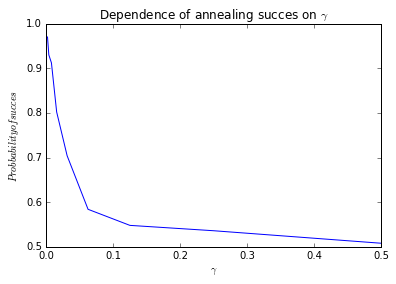

In [7]:
pylab.title('Dependence of annealing succes on $\gamma$')
pylab.plot(gammas, prob)
pylab.xlabel('$\gamma$')
pylab.ylabel('$Probbability of succes$')
pylab.show()

Study Preparation program 1, in particular its annealing schedule where, after each 100 iterations, the temperature is rescaled following 

T -> T * (1 - gamma) (Simulated annealing step)

compute (by simply running the program, once you have understood it) the approximate probability with which the correct solution $x \sim 1.614$ is found for $\gamma = 0.5, 0.25, 0.125 ... 0.002$ (approximately). Convince yourself that 

1. for finite annealing rate gamma, the correct solution is not necessarily found in the limit $t \to \infty$.
2. the correct solution is found with probability 1 for $t \to \infty$ in the limit of vanishing annealing rate ($\gamma \to 0$).

# QUESTION

1. Supply a table or display a figure showing your results for probability vs gamma for very large times.

NB: Both your observations here are backed by mathematical theorems: For smooth potentials, simulated annealing is guaranteed to find the ground-state in the limit of infinite time in the limit of infinitely slow annealing. However, these theorems are not really useful in practice.

## A2

We now imagine a thought experiment, consisting in a hard disk located in the container shown below. An actual implementation is neither required nor expected. The container has two boxes connected through a hard bottleneck. All its contours, and in particular the bottleneck, are made of hard walls.

![Bottleneck](./Figures/bottle_neck.png "Bottleneck")

Imagine that we perform a Monte Carlo simulation with displacements (x,y) -> (x + delx, y + dely), where delx, dely (that can be positive or negative) are much smaller than the dimensions of the container. After each 100 iterations, the disk radius is increased as follows:

sigma -> sigma * (1 + gamma) with gamma > 0 (simulated annealing step),

if it is possible (if there is an overlap, no action is taken). We want to find the largest disk fitting into the container.
Convince yourself that simulated annealing for this case does NOT FIND WITH PROBABILITY 1 the optimal solution (disk to the right) in the limit $t \to \infty$, even for $\gamma \to 0$. 

# QUESTION

1. Write down a short explanation of why this is so.

## Answer

1. Well, first of all if speed how disk size is increase is fast (large gamma) .. reults would be purely dependent on initial conditions ... in other words where we palce disk at begining. Howvever, if increase in size would be very slow ... or at least very slow at begining ( for example if first incerase in size would be after time when probability of having disk any where in system is same), then probability of having result of maximal size of small or large container should be proportional to areas of small and large container respectively ... however it would never reach 100% chance to give "corect" result since even in infinitely small gamma limit once disk reach size of bottle neck width, system si quenched in one solution only. And most importantly there is no reason why annealing should finde solution of largest disk at first place since there is no energy difference between larger and smaller disk ...

# B

Here we perform simulated annealing for the disk-packing problem. For simplicity, you may use the program below. Note also that we only output configurations that are above a given density min_density.

In [18]:
def unit_sphere():
    x = [random.gauss(0.0, 1.0) for i in range(3)]
    norm = math.sqrt(sum(xk ** 2 for xk in x))
    return [xk / norm for xk in x]

def minimum_distance(positions, N):
    dists = [math.sqrt(sum((positions[k][j] - positions[l][j]) ** 2 
                           for j in range(3))) 
             for l in range(N)
             for k in range(l)]
    return min(dists)

def resize_disks(positions, r, N, gamma):
    Upsilon = minimum_distance(positions, N) / 2.0
    r = r + gamma * (Upsilon - r)
    return r


def sphereOnSphere(N=13, gamma=0.5, min_density=0.78, sigma0=0.25, n_iter=100):
    results={}
    for iteration in range(n_iter):
#        print iteration
        sigma = sigma0
        r = 0.0
        positions = [unit_sphere() for j in range(N)]
        n_acc = 0
        step = 0
        while sigma > 1.e-8:
            step += 1
            if step % 500000 == 0:
                eta = N / 2.0 * (1.0 - math.sqrt(1.0 - r ** 2))
#                print r, eta, sigma, acc_rate
            k = random.randint(0, N - 1)
            newpos = [positions[k][j] + random.gauss(0, sigma) for j in range(3)]
            norm = math.sqrt(sum(xk ** 2 for xk in newpos))
            newpos = [xk / norm for xk in newpos]
            new_min_dist = min([math.sqrt(sum((positions[l][j] - newpos[j]) ** 2 
                                              for j in range(3))) 
                                for l in range(k) + range(k + 1, N)])
            if new_min_dist > 2.0 * r:
                positions = positions[:k] + [newpos] + positions[k + 1:]
                n_acc += 1
            if step % 100 == 0:
                acc_rate = n_acc / float(100)
                n_acc = 0
                if acc_rate < 0.2:
                    sigma *= 0.5
                elif acc_rate > 0.8 and sigma < 0.5:
                    sigma *= 2.0
                r = resize_disks(positions, r, N, gamma)
                R = 1.0 / (1.0 / r - 1.0)
                eta = 1.0 * N / 2.0 * (1.0 - math.sqrt(1.0 - r ** 2))
#        print 'final density: %f (gamma = %f)' % (eta, gamma)
        if eta > min_density:
            results.update({eta:positions})
            f = open('N_' + str(N) + '_final_'+ str(eta) + '.txt', 'w')
            for a in positions:
                f.write(str(a[0]) + ' ' + str(a[1]) + ' ' + str(a[2]) + '\n')
            f.close()
    return results

Note the role of the following in this program:
1. $R = \dfrac{1}{1/r -1}$ relation between outer-sphere radius R and disk radius r
2. $\eta = N * (1 - \sqrt{1 - r^2}) / 2$ surface area of the spherical caps formed by the disks.

## B1

Run the simulated annealing program for N = 13 disks on a sphere. Experiment with its various parameters, especially with the annealing rate gamma, and the control parameter sigma, that sets the step width of the Markov chain.

NB: Remember that step-width adjustment during a Monte Carlo calculation used for integration is FORBIDDEN.

Use somewhat smaller values of gamma to recover the conjectured optimal solution for N=13, that has density $\eta = 0.79139$, and a sub-optimal solution with density $\eta = 0.78639$.

# QUESTIONS

1. indicate which value of $\gamma$ you found most appropriate.
1. Display the positions x,y,z as output by the program, for both configurations introduced in the text above.
2. For small annealing rates, do you ALWAYS recover the optimal solution (case discussed in section A1) or do you find that you continue to find different solutions even for small annealing rates (case discussed in section A2)?

NB: While it is proven that $R < 1$ for $N = 13$, it has not been proven that the solution with eta = 0.79139 is actually the best one.

maximal density we found: 0.791393


<IPython.core.display.Javascript object>


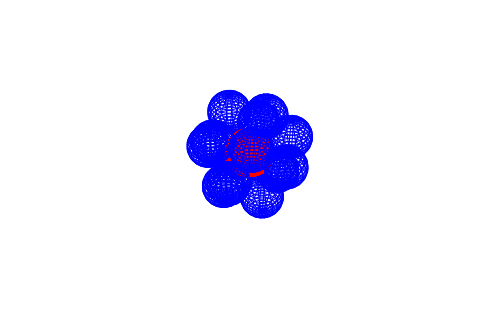

In [23]:
res = sphereOnSphere(N=13, gamma=0.2, min_density=0.78, sigma0=0.25, n_iter=20)
best = max(res.keys())
print "maximal density we found: %f"%(best)
draw_configuration(res[best])

<IPython.core.display.Javascript object>


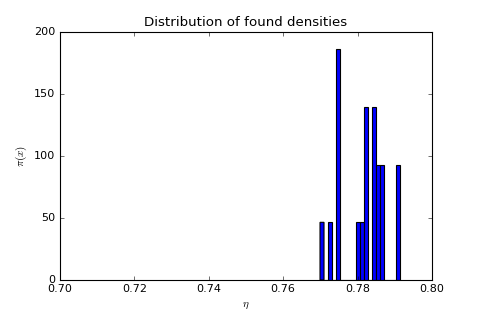

In [28]:
pylab.title('Distribution of found densities')
pylab.hist(res.keys(), bins=20, normed=True)
pylab.xlim(0.7,0.8)
pylab.xlabel('$\eta$')
pylab.ylabel('$\\pi(x)$')
pylab.show()

Well even for small gamma we still sometimes do not converge to the optimal solution.

Closest density to suboptimal solution eta = 0.78639: 0.778806


<IPython.core.display.Javascript object>


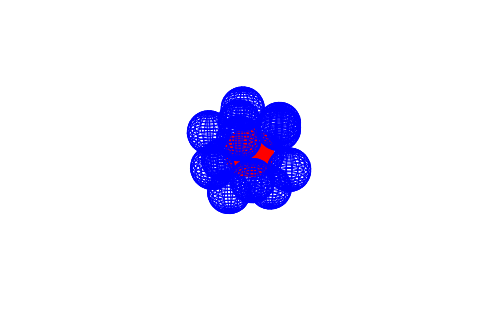

In [29]:
res2 = sphereOnSphere(N=13, gamma=0.5, min_density=0.78, sigma0=0.25, n_iter=20)
best = 1000000
for i in res2.keys():
    if abs(i-0.78639) < best:
        best = i
print "Closest density to suboptimal solution eta = 0.78639: %f"%(best)
draw_configuration(res2[best])

## B2

# QUESTIONS

1. Find the optimal solution for N = 15 (it should have density $\eta = 0.80731$)
2. Display the positions x,y,z as output by the program for this optimal density.
3. Optional (zero points to be gained): In fact, for N=15, prove that there are TWO optimal solutions at the same density. (Write a program checking that only in one of them, the 5-connected disks touch each other.)

maximal density we found: 0.807314


<IPython.core.display.Javascript object>


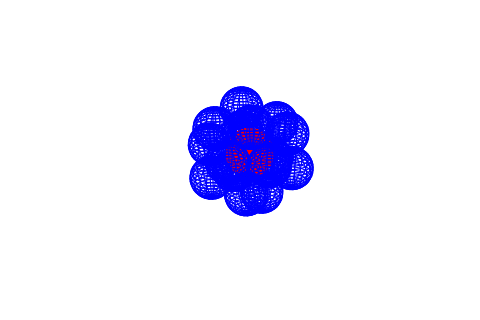

In [30]:
res3 = sphereOnSphere(N=15, gamma=0.2, min_density=0.79, sigma0=0.25, n_iter=20)
best = max(res3.keys())
print "maximal density we found: %f"%(best)
draw_configuration(res3[best])

In [32]:
def maxNumberOfConections(positions):
    N = len(positions)
    distances = [[] for in xrange(N)]
    for i in xrange(N):
        for j in xrange(N-1):
            pass
k = [ [] for i in xrange(2)] 
print k

[[], []]


## B3 

# QUESTIONS

1. Find the optimal solution for $N = 19$ (it should have density $\eta = 0.81096$). 
2. Display the positions x,y,z as output by the program for this optimal density.
3. Optional (zero points to be gained): Show that there are infinitely many optimal solutions, as one of the 19 disks is not jammed. (Write a program checking that one of the 19 disks is one-connected. This special disk has only one shortest distance).

NB: Configurations of parts B2 and B3 were found by D. A. Kottwitz (1991) using a very complex optimization program.

maximal density we found: 0.810798


<IPython.core.display.Javascript object>


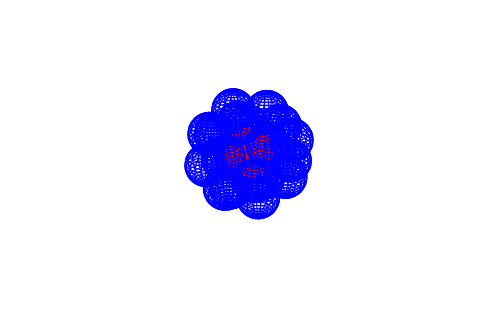

In [31]:
res4 = sphereOnSphere(N=19, gamma=0.2, min_density=0.80, sigma0=0.25, n_iter=20)
best = max(res4.keys())
print "maximal density we found: %f"%(best)
draw_configuration(res4[best])

# C

Here we consider the travelling salesman problem (TSP), one of the classic problems in combinatorial optimization: given $N$ cities, with distances $d(i,j) = d(j,i)$ between them, find the shortest closed tour visiting all of them. The TSP is a prominent example of the class of NP complete problems, for which it is very difficult to find a solution, but this solution is easy to check. We will apply simulated annealing to the TSP in two dimensions. Simulated annealing provides a very interesting first approach to this problem.

## C1

Before simulated annealing, let us try a direct-sampling approach. For this, use the below program.

In [40]:
def dist(x, y):
    return math.sqrt((x[0] -y[0]) ** 2 + (x[1] - y[1]) ** 2)

def tour_length(cities, N):
    return (sum (dist(cities[k + 1], cities[k]) 
                for k in range(N - 1)) 
            + dist(cities[0], cities[N - 1]))

def direcApproach(N, seed, n_iter):
    lengths = [[],[]]
    random.seed(seed)
    cities = [(random.uniform(0.0, 1.0), random.uniform(0.0, 1.0)) for i in range(N)]
    random.seed()
    energy_min = float('inf')

    for i in xrange(n_iter):
        random.shuffle(cities)
        energy = tour_length(cities, N)
        if energy < energy_min:
            lengths[0].append(i)
            lengths[1].append(energy)
#            print energy
            energy_min = energy
            new_cities = cities[:]

    cities = new_cities[:]
    for i in range(1,N):
        pylab.plot([cities[i][0], cities[i - 1][0]], [cities[i][1], cities[i - 1][1]], 'bo-')
    pylab.plot([cities[0][0], cities[N - 1][0]], [cities[0][1], cities[N - 1][1]], 'bo-')
    pylab.title(str(energy_min))
    pylab.axis('scaled')
    pylab.axis([0.0, 1.0, 0.0, 1.0])
    pylab.savefig('TSP_configuration.png')
    pylab.show()
    return lengths

Study this program. Notice that any tour is given by a random permutation of the cities. Notice also that the random number generator is initialized by a seed in order to generate an instance (positions of the $N$ cities), but is then randomized. Subsequent runs of the program produce the same instance, but then the program uses different random numbers at each run.

# QUESTIONS

1. Run the program several times for $N=10$, for $10^6$ iterations each (You may change the seed). Do you get the impression that you have obtained the optimal tour length? 
2. Explain briefly your observations and upload the "optimal" tour (by a visual control of the graphic representation of the tour).
3. Run the program several times for $N=20$, for $10^6$ iterations each (You may change the seed). Do you get the impression that you have obtained the optimal tour length?
4. Explain briefly your observations and display the figure representing the "optimal" tour.

<IPython.core.display.Javascript object>


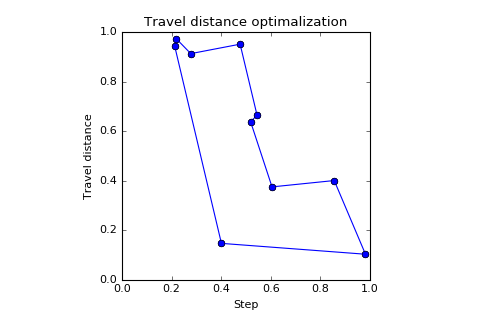

In [41]:
res01 = direcApproach(10, 18974149498, 1000000)

<IPython.core.display.Javascript object>


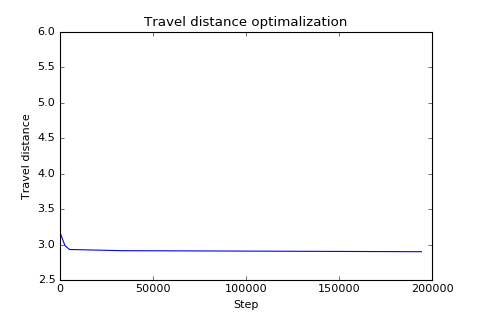

In [42]:
pylab.title('Travel distance optimalization')
pylab.plot(res01[0], res01[1])
pylab.xlabel('Step')
pylab.ylabel('Travel distance')
pylab.show()

Well it seems we reach minimal path quite fast for 10 cities, so that primitive algorithm with shuffling cities works for such small number of different possible travel paths.

<IPython.core.display.Javascript object>


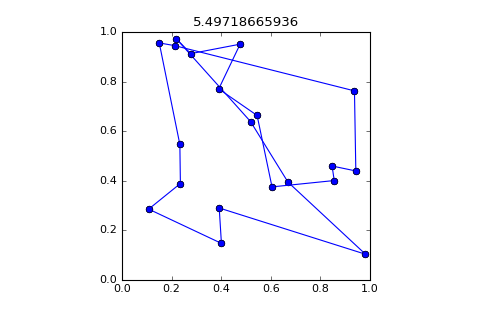

In [94]:
res02 = direcApproach(20, 18974149498, 3000000)

<IPython.core.display.Javascript object>


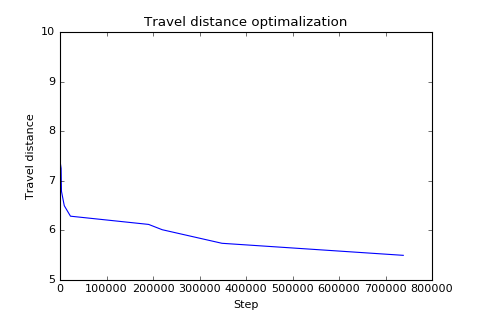

In [95]:
pylab.title('Travel distance optimalization')
pylab.plot(res02[0], res02[1])
pylab.xlabel('Step')
pylab.ylabel('Travel distance')
pylab.show()

Well for 20 cities random shuffling algorithms seems to not work since even after $10^6$ steps till length of path is decreasing. So I would be skeptical about statement that we found shortest path, sunce number of possible paths increase rapidly with number of cities.

## C2

Now let us do simulated annealing, using the length of the tour as the quantity to be minimized. Use the below program, that you are free to run and to modify.

In [85]:
def dist(x, y):
    return math.sqrt((x[0] -y[0]) ** 2 + (x[1] - y[1]) ** 2)
def tour_length(cities, N):
    return (sum (dist(cities[k + 1], cities[k])
                 for k in range(N - 1)) 
            + dist(cities[0], cities[N - 1]))

def annealingApproach(N, seed, n_iter):
    lengths = [[],[]]
    random.seed(seed)
    cities = [(random.uniform(0.0, 1.0), random.uniform(0.0, 1.0)) for i in range(N)]
    random.seed()
    random.shuffle(cities)

    beta = 1.0
    n_accept = 0
    best_energy = 10000.0
    energy = tour_length(cities, N)
    for i in xrange(n_iter):
        if n_accept == 100:
            beta *= 1.005
            n_accept = 0
        p = random.uniform(0.0, 1.0)
        if p < 0.2:
            i = random.randint(0, N / 2)
            cities = cities[i:] + cities[:i]
            i = random.randint(0, N / 2)
            a = cities[:i]
            a.reverse()
            new_cities = a + cities[i:]
        elif p < 0.6:
            new_cities = cities[:]
            i = random.randint(1, N - 1)
            a = new_cities.pop(i)
            j = random.randint(1, N - 2)
            new_cities.insert(j, a)
        else:
            new_cities = cities[:]
            i = random.randint(1, N - 1)
            j = random.randint(1, N - 1)
            new_cities[i] = cities[j]
            new_cities[j] = cities[i]
        new_energy = tour_length(new_cities, N)
        if random.uniform(0.0, 1.0) < math.exp(- beta * (new_energy - energy)):
            n_accept += 1
            energy = new_energy
            cities = new_cities[:]
            if energy < best_energy:
                best_energy = energy
                best_tour = cities[:]
                lengths[0].append(1.0 / beta)
                lengths[1].append(energy)
#        if i % 100000 == 0:
#            print energy, i, 1.0 / beta

    cities = best_tour[:]
    for i in range(1,N):
        pylab.plot([cities[i][0], cities[i - 1][0]], [cities[i][1], cities[i - 1][1]], 'bo-')
    pylab.plot([cities[0][0], cities[N - 1][0]], [cities[0][1], cities[N - 1][1]], 'bo-')
    pylab.title(str(best_energy))
    pylab.axis('scaled')
    pylab.axis([0.0, 1.0, 0.0, 1.0])
    pylab.savefig('simulated_annealing_best_path_N%i.png' % N)
    return lengths

Three types of moves are implemented in this program. Make sure you understand these moves (no need to write them up).

# QUESTIONS

1. Run the program for the same instance as in C1, for $N=10$. Do you find the same solution, or even a better solution?
2. Display the figure showing the best solution you found.
3. Run the program for the same instance as in C1, for $N=20$. Do you find the same solution, or even a better solution?
4. Display the figure showing the best solution you found.
5. Run the program for $N=50$. Do you think that the program finds the optimal solution or can you see, by visual inspection, that the solution found is sub-optimal? 
6. Display the figure showing the best solution you found.

NB: Don't hesitate to experiment with larger values of N, different moves, etc.

<IPython.core.display.Javascript object>


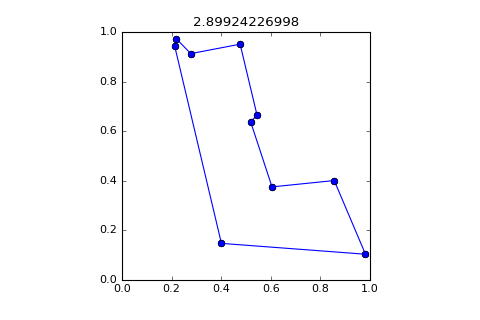

In [86]:
res11 = annealingApproach(10, 18974149498, 1000000)

<IPython.core.display.Javascript object>


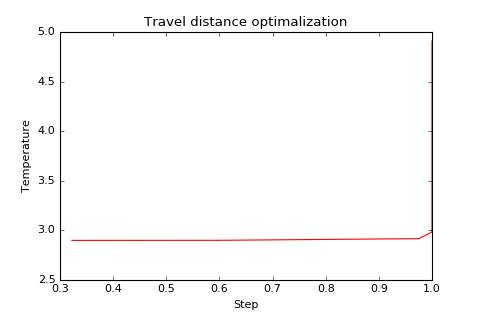

In [87]:
pylab.title('Travel distance optimalization')
pylab.plot(res11[0], res11[1], color='r')
pylab.xlabel('Step')
pylab.ylabel('Temperature')
pylab.show()

Well both approaches converged to same length of minimal path, since in case of direct sampling we were able t sample all possible permutations of cities so that minimal path was sampled and found.

<IPython.core.display.Javascript object>


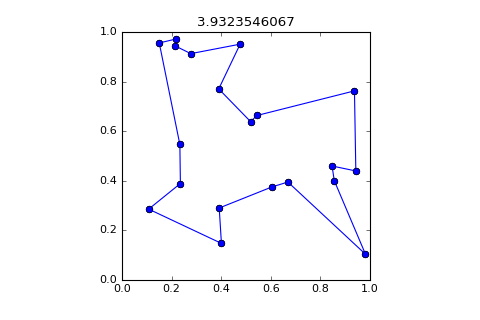

In [90]:
res12 = annealingApproach(20, 18974149498, 3000000)

<IPython.core.display.Javascript object>


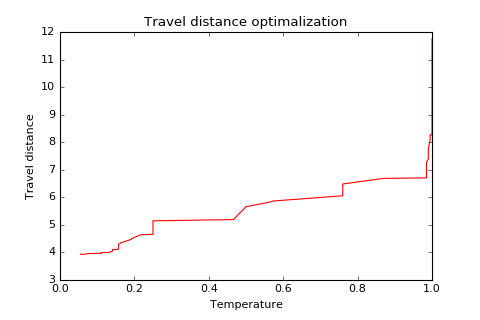

In [91]:
pylab.title('Travel distance optimalization')
pylab.plot(res12[0], res12[1], color='r')
pylab.xlabel('Temperature')
pylab.ylabel('Travel distance')
pylab.show()

In case of 20 cities direct sampling was not able to sample all possible permutations of cities so that optimal solution was not found, however in simulated annealing, we can see convergence toward some minimal path length. Problem is that we can not say if minimal path is local or global. However, from visual inspection of path it seems to be reasonable while in case C1 for 20 cities we can see quite unfavourable travel from top to bottom.

From this we might conclude simulated annealing (eventhough not able to give exact minimal solution in finite time0 is faster converging toward minimum then direct random sampling.

<IPython.core.display.Javascript object>


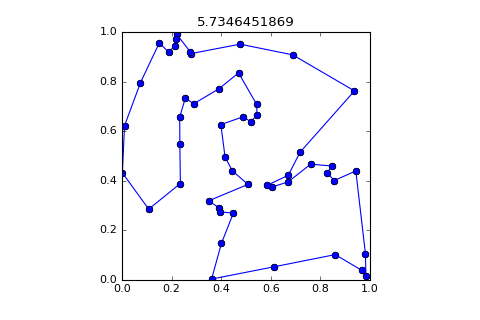

In [92]:
res13 = annealingApproach(50, 18974149498, 5000000)

<IPython.core.display.Javascript object>


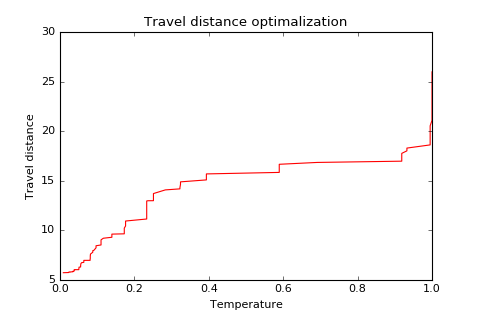

In [93]:
pylab.title('Travel distance optimalization')
pylab.plot(res13[0], res13[1], color='r')
pylab.xlabel('Temperature')
pylab.ylabel('Travel distance')
pylab.show()

Here we can see that despite large number of cities and posible paths, simulated annealing is converging toward local/global minima, where direct random sampling would probably never be able to sample any minima. Also path given in figure seems to be reasonable.